<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>APRENDIZADO DE MÁQUINA (GCC1932) - Trabalho 3</center></h1>

- Nome completo: Bianca Gallicchio Tavares
- [Link para vídeo](https://youtu.be/pR8AvE2IriM)

## Imports

In [1]:
# 0. Imports necessários
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pickle
import os

# Configurações iniciais
plt.style.use('ggplot')
sns.set_palette("husl")
np.random.seed(42)

## Carregando o dataset


Shapes dos conjuntos de dados:
Treino: X(235118, 47), y(235118,)
Validação: X(187980, 47), y(187980,)
Teste: X(91275, 47), y(91275,)

Estatísticas dos casos de dengue:
Total de casos no conjunto de treino: 47117
Média de casos por semana: 0.20
Máximo de casos em uma semana: 337


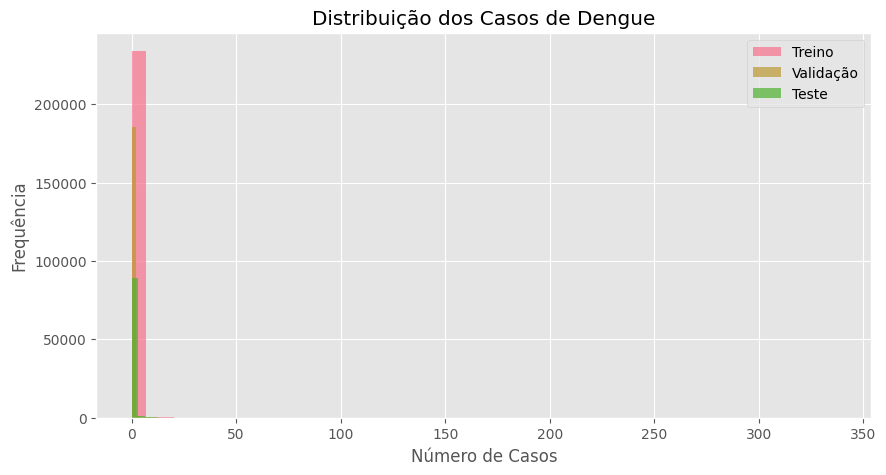

In [2]:
# 1. Carregamento e Exploração dos Dados
# ======================================

def load_dataset(path):
    """Carrega o dataset pickle e retorna os conjuntos de dados"""
    with open(path, "rb") as file:
        data = pickle.load(file)
    return data

# Carregando os dados semanais com variáveis climáticas
(X_train, y_train, X_val, y_val, X_test, y_test) = load_dataset('DATASETS/RJ_WEEKLY/dataset.pickle')

print("\nShapes dos conjuntos de dados:")
print(f"Treino: X{X_train.shape}, y{y_train.shape}")
print(f"Validação: X{X_val.shape}, y{y_val.shape}")
print(f"Teste: X{X_test.shape}, y{y_test.shape}")

# Verificando a distribuição dos casos
print("\nEstatísticas dos casos de dengue:")
print(f"Total de casos no conjunto de treino: {y_train.sum()}")
print(f"Média de casos por semana: {y_train.mean():.2f}")
print(f"Máximo de casos em uma semana: {y_train.max()}")

# Plotando a distribuição dos casos
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=50, alpha=0.7, label='Treino')
plt.hist(y_val, bins=50, alpha=0.7, label='Validação')
plt.hist(y_test, bins=50, alpha=0.7, label='Teste')
plt.title('Distribuição dos Casos de Dengue')
plt.xlabel('Número de Casos')
plt.ylabel('Frequência')
plt.legend()
plt.show()

### Dicionário de Features

Este dicionário é gerado automaticamente durante a criação do dataset, baseado nas colunas do DataFrame final antes da conversão para NumPy.

1. **TEM_AVG**: Temperatura média diária (°C)
2. **TEM_MIN**: Temperatura mínima diária (°C)
3. **TEM_MAX**: Temperatura máxima diária (°C)
4. **RAIN**: Precipitação total diária (mm)
5. **RH_AVG**: Umidade relativa média do dia (%)
6. **RH_MIN**: Umidade relativa mínima do dia (%)
7. **RH_MAX**: Umidade relativa máxima do dia (%)
8. **IDEAL_TEMP**: Temperatura ideal para eclosão de ovos e amadurecimento do mosquito (°C)
9. **EXTREME_TEMP**: Temperatura nociva para o mosquito (°C)
10. **SIGNIFICANT_RAIN**: Chuva significativa capaz de criar novos criadouros (mm)
11. **EXTREME_RAIN**: Chuva extrema que remove ovos do ambiente (mm)
12. **TEMP_RANGE**: Amplitude térmica do dia (°C)
13. **WEEK_OF_YEAR**: Semana epidemiológica (1 a 52)
14. **TEM_AVG_MM_7**: Média móvel (ex: suavização de valores anteriores)
15. **CASES_MM_7**: Número de casos reportados
16. **CASES_ACC_7**: Número de casos reportados
17. **RAIN_ACC_7**: Valor acumulado (soma ao longo do tempo)
18. **RAIN_MM_7**: Média móvel (ex: suavização de valores anteriores)
19. **RH_MM_7**: Média móvel (ex: suavização de valores anteriores)
20. **TEMP_RANGE_MM_7**: Amplitude térmica do dia (°C)
21. **TEM_AVG_MM_14**: Média móvel (ex: suavização de valores anteriores)
22. **CASES_MM_14**: Número de casos reportados
23. **CASES_ACC_14**: Número de casos reportados
24. **RAIN_ACC_14**: Valor acumulado (soma ao longo do tempo)
25. **RAIN_MM_14**: Média móvel (ex: suavização de valores anteriores)
26. **RH_MM_14**: Média móvel (ex: suavização de valores anteriores)
27. **TEMP_RANGE_MM_14**: Amplitude térmica do dia (°C)
28. **TEM_AVG_MM_21**: Média móvel (ex: suavização de valores anteriores)
29. **CASES_MM_21**: Número de casos reportados
30. **CASES_ACC_21**: Número de casos reportados
31. **RAIN_ACC_21**: Valor acumulado (soma ao longo do tempo)
32. **RAIN_MM_21**: Média móvel (ex: suavização de valores anteriores)
33. **RH_MM_21**: Média móvel (ex: suavização de valores anteriores)
34. **TEMP_RANGE_MM_21**: Amplitude térmica do dia (°C)
35. **TEM_AVG_MM_28**: Média móvel (ex: suavização de valores anteriores)
36. **CASES_MM_28**: Número de casos reportados
37. **CASES_ACC_28**: Número de casos reportados
38. **RAIN_ACC_28**: Valor acumulado (soma ao longo do tempo)
39. **RAIN_MM_28**: Média móvel (ex: suavização de valores anteriores)
40. **RH_MM_28**: Média móvel (ex: suavização de valores anteriores)
41. **TEMP_RANGE_MM_28**: Amplitude térmica do dia (°C)
42. **CASES_LAG_1**: Número de casos reportados
43. **CASES_LAG_2**: Número de casos reportados
44. **CASES_LAG_3**: Número de casos reportados
45. **CASES_LAG_4**: Número de casos reportados
46. **CASES_LAG_5**: Número de casos reportados
47. **CASES_LAG_6**: Número de casos reportados



Dicionário de Variáveis:
    Index           Feature
0       0           TEM_AVG
1       1           TEM_MIN
2       2           TEM_MAX
3       3              RAIN
4       4            RH_AVG
5       5            RH_MIN
6       6            RH_MAX
7       7        CASES_MM_7
8       8       CASES_MM_14
9       9       CASES_MM_21
10     10       CASES_MM_28
11     11       CASES_ACC_7
12     12      CASES_ACC_14
13     13      CASES_ACC_21
14     14      CASES_ACC_28
15     15       CASES_LAG_1
16     16       CASES_LAG_2
17     17       CASES_LAG_3
18     18       CASES_LAG_4
19     19       CASES_LAG_5
20     20       CASES_LAG_6
21     21        IDEAL_TEMP
22     22      EXTREME_TEMP
23     23  SIGNIFICANT_RAIN
24     24      EXTREME_RAIN
25     25        TEMP_RANGE
26     26      WEEK_OF_YEAR
27     27      TEM_AVG_MM_7
28     28        RAIN_ACC_7
29     29         RAIN_MM_7
30     30           RH_MM_7
31     31   TEMP_RANGE_MM_7
32     32     TEM_AVG_MM_14
33     33       RAIN_A

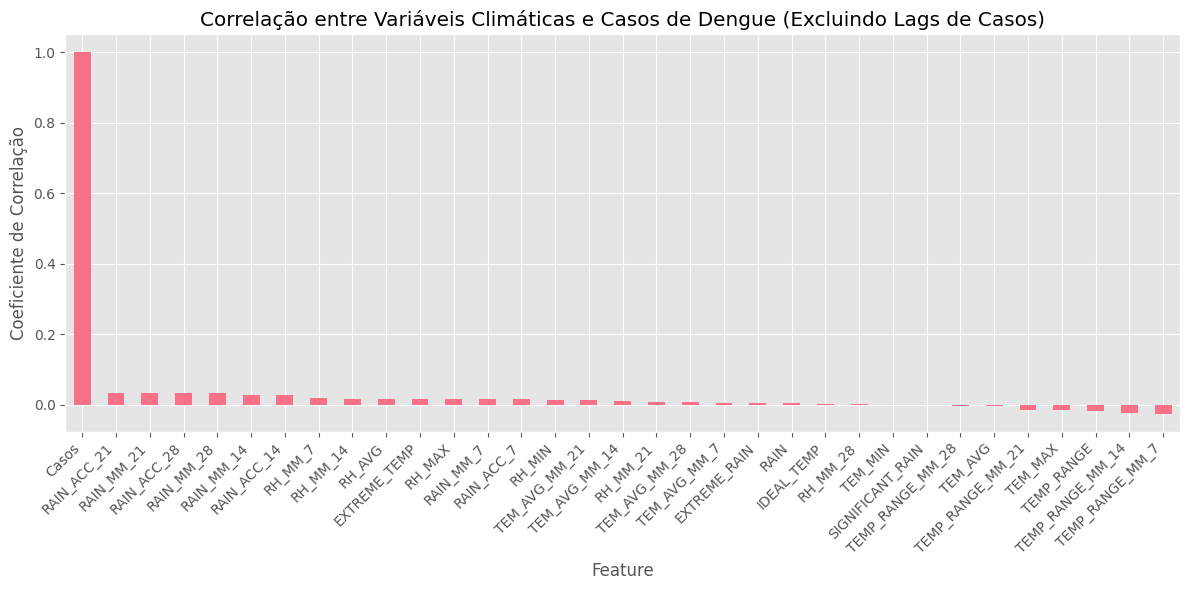


Top 10 variáveis CLIMÁTICAS mais correlacionadas com Casos de Dengue:
Feature
RAIN_ACC_21     0.032468
RAIN_MM_21      0.032468
RAIN_ACC_28     0.031881
RAIN_MM_28      0.031881
RAIN_MM_14      0.027074
RAIN_ACC_14     0.027074
RH_MM_7         0.018568
RH_MM_14        0.016504
RH_AVG          0.015392
EXTREME_TEMP    0.014736
Name: Casos, dtype: float64

Top 10 variáveis CLIMÁTICAS mais negativamente correlacionadas com Casos de Dengue:
Feature
WEEK_OF_YEAR       -0.031065
TEMP_RANGE_MM_7    -0.025737
TEMP_RANGE_MM_14   -0.023960
TEMP_RANGE         -0.017104
TEM_MAX            -0.015629
TEMP_RANGE_MM_21   -0.014926
TEM_AVG            -0.003996
TEMP_RANGE_MM_28   -0.003591
SIGNIFICANT_RAIN   -0.002144
TEM_MIN            -0.001036
Name: Casos, dtype: float64


In [3]:
# 2. Análise Exploratória Detalhada
# =================================

# Carregando o dicionário de features para entender as variáveis
feature_dict = pd.read_csv('DATASETS/RJ_WEEKLY/feature_dictionary.csv')
print("\nDicionário de Variáveis:")
print(feature_dict)

# Verificando a dimensionalidade dos dados
print("\nDimensionalidade dos dados:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Lista de variáveis de casos que devem ser excluídas da análise de correlação
cases_related_vars = [
    'CASES_MM_7', 'CASES_ACC_7', 'CASES_MM_14', 'CASES_ACC_14',
    'CASES_MM_21', 'CASES_ACC_21', 'CASES_MM_28', 'CASES_ACC_28',
    'CASES_LAG_1', 'CASES_LAG_2', 'CASES_LAG_3', 'CASES_LAG_4',
    'CASES_LAG_5', 'CASES_LAG_6'
]

# Criando DataFrame temporário apenas com variáveis climáticas/ambientais
climate_vars = [f for f in feature_dict['Feature'] if f not in cases_related_vars]
df_train_climate = pd.DataFrame(X_train, columns=feature_dict['Feature'])
df_train_climate = df_train_climate[climate_vars]
df_train_climate['Casos'] = y_train

# Calculando correlações apenas com variáveis climáticas
corr_matrix_climate = df_train_climate.corr()

# Plotando as correlações com os casos (apenas variáveis climáticas)
plt.figure(figsize=(12, 6))
corr_matrix_climate['Casos'].sort_values(ascending=False)[:-1].plot(kind='bar')  # [:-1] para excluir a correlação consigo mesmo
plt.title('Correlação entre Variáveis Climáticas e Casos de Dengue (Excluindo Lags de Casos)')
plt.ylabel('Coeficiente de Correlação')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Mostrando as 10 variáveis climáticas mais correlacionadas
print("\nTop 10 variáveis CLIMÁTICAS mais correlacionadas com Casos de Dengue:")
print(corr_matrix_climate['Casos'].sort_values(ascending=False).head(11)[1:])  # Pula a correlação consigo mesmo

print("\nTop 10 variáveis CLIMÁTICAS mais negativamente correlacionadas com Casos de Dengue:")
print(corr_matrix_climate['Casos'].sort_values().head(10))

In [19]:
# 3. Pré-processamento dos Dados
# ==============================

def create_sequences(X, y, window_size=4):
    """Cria janelas temporais para os dados"""
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Tamanho da janela temporal (semanas anteriores usadas como entrada)
window_size = 4

# Criando sequências temporais
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

print("\nShapes após criação das sequências temporais:")
print(f"Treino: X{X_train_seq.shape}, y{y_train_seq.shape}")
print(f"Validação: X{X_val_seq.shape}, y{y_val_seq.shape}")
print(f"Teste: X{X_test_seq.shape}, y{y_test_seq.shape}")

# Normalização dos dados - agora separando por feature
scaler = MinMaxScaler()

# Como nossos dados agora são 3D (amostras, timesteps, features), precisamos normalizar corretamente
n_samples, n_timesteps, n_features = X_train_seq.shape

# Reformulando para (amostras*timesteps, features) para normalização
X_train_reshaped = X_train_seq.reshape(-1, n_features)
X_val_reshaped = X_val_seq.reshape(-1, n_features)
X_test_reshaped = X_test_seq.reshape(-1, n_features)

# Ajustando o scaler apenas nos dados de treino
scaler.fit(X_train_reshaped)

# Normalizando todos os conjuntos
X_train_norm = scaler.transform(X_train_reshaped).reshape(n_samples, n_timesteps, n_features)
X_val_norm = scaler.transform(X_val_reshaped).reshape(X_val_seq.shape[0], n_timesteps, n_features)
X_test_norm = scaler.transform(X_test_reshaped).reshape(X_test_seq.shape[0], n_timesteps, n_features)


Shapes após criação das sequências temporais:
Treino: X(235114, 4, 47), y(235114,)
Validação: X(187976, 4, 47), y(187976,)
Teste: X(91271, 4, 47), y(91271,)


## Modelo LSTM


Resumo do Modelo LSTM:


c:\Users\User\anaconda3\envs\dengue_dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 4, 64)          │        28,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,121 (160.63 KB)

 Trainable params: 41,121 (160.63 KB)

 Non-trainable params: 0 (0.00 B)


Treinando o modelo LSTM...
Epoch 1/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 13.6544 - val_loss: 1.9672 - learning_rate: 0.0010
Epoch 2/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 10.9046 - val_loss: 1.9055 - learning_rate: 0.0010
Epoch 3/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 9.2950 - val_loss: 1.6626 - learning_rate: 0.0010
Epoch 4/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 7.4575 - val_loss: 1.4244 - learning_rate: 0.0010
Epoch 5/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 8.4231 - val_loss: 1.3799 - learning_rate: 0.0010
Epoch 6/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 5.5168 - val_loss: 1.4397 - learning_rate: 0.0010
Epoch 7/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 5.7446 - val_loss: 1.3738 - learning_rate: 0.0010
Epoch 8/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 6.3764 - val_loss: 1.4628 - learning_rate: 0.0010
Epoch 9/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 5.

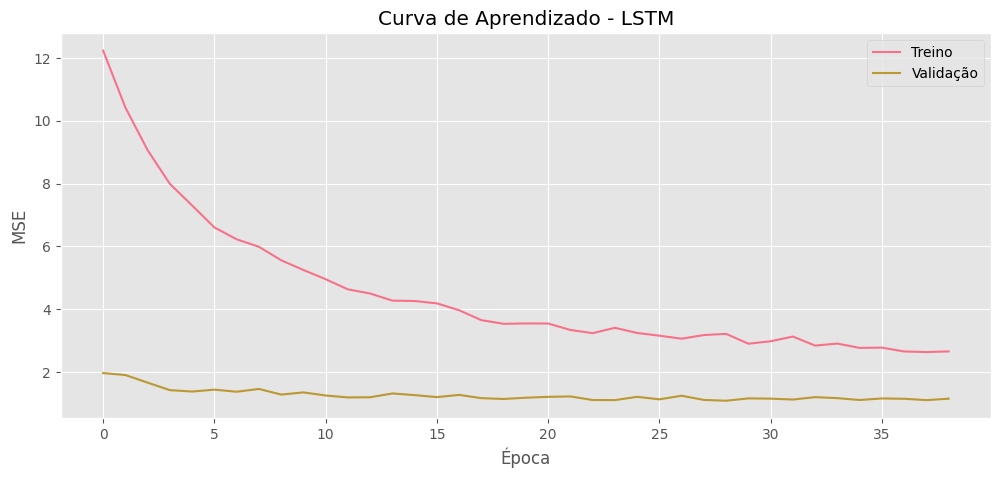

In [20]:
# 4. Modelagem - LSTM
# ===================

def build_lstm_model(input_shape):
    """Constroi e compila um modelo LSTM"""
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Construindo o modelo LSTM
lstm_model = build_lstm_model((window_size, X_train_norm.shape[2]))
print("\nResumo do Modelo LSTM:")
lstm_model.summary()

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
]

# Treinamento do LSTM
print("\nTreinando o modelo LSTM...")
history_lstm = lstm_model.fit(
    X_train_norm, y_train_seq,
    validation_data=(X_val_norm, y_val_seq),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# Plotando o histórico de treinamento
plt.figure(figsize=(12, 5))
plt.plot(history_lstm.history['loss'], label='Treino')
plt.plot(history_lstm.history['val_loss'], label='Validação')
plt.title('Curva de Aprendizado - LSTM')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend()
plt.show()

## Modelo Conv1D


Resumo do Modelo Conv1D:


c:\Users\User\anaconda3\envs\dengue_dl\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 4, 32)          │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 2, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,681 (37.82 KB)

 Trainable params: 9,681 (37.82 KB)

 Non-trainable params: 0 (0.00 B)


Treinando o modelo Conv1D...
Epoch 1/60
7348/7348 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1678.8530 - mae: 4.4231 - val_loss: 93.5717 - val_mae: 0.3794 - learning_rate: 0.0010
Epoch 2/60
7348/7348 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1402.5282 - mae: 2.6848 - val_loss: 96.9469 - val_mae: 0.6347 - learning_rate: 0.0010
Epoch 3/60
7348/7348 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 821.2800 - mae: 1.7525 - val_loss: 89.2056 - val_mae: 1.1159 - learning_rate: 0.0010
Epoch 4/60
7348/7348 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 715.9502 - mae: 1.9150 - val_loss: 77.2250 - val_mae: 1.2938 - learning_rate: 0.0010
Epoch 5/60
7348/7348 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 530.4116 - mae: 1.7522 - val_loss: 123.5727 - val_mae: 2.4895 - learning_rate: 0.0010
Epoch 6/60
7348/7348 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1051.5880 - mae: 2.3166 - val_loss: 93.5238 - val_mae: 1.3949 - learning_rate: 0.0010
Epoch 7/60
7348/7348 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1284.1964 - mae

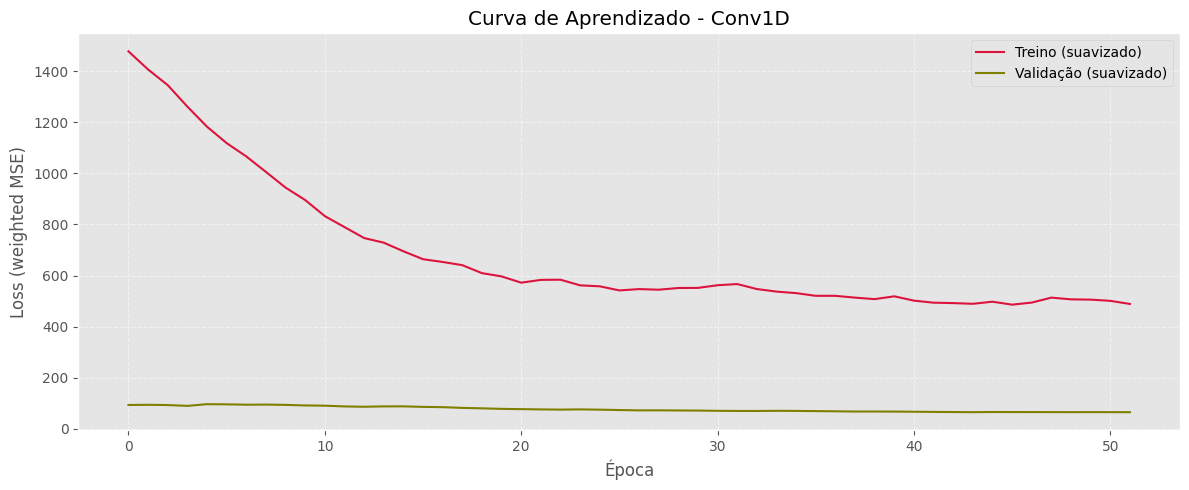

In [ ]:
# 5. Modelagem - Conv1D
# ========================================

def weighted_mse(y_true, y_pred):
    # Exemplo: peso maior para valores maiores de y_true
    weights = tf.math.abs(y_true) + 1.0
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

def build_conv1d_model(input_shape):
    """Constroi e compila um modelo Conv1D para séries temporais"""
    model = Sequential([
        # Primeira camada Conv1D
        Conv1D(filters=64, kernel_size=3, activation='relu', 
               input_shape=input_shape, padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Segunda camada Conv1D
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=1),  # Não reduz dimensão
        Dropout(0.3),
        
        # Camada final
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss=weighted_mse,
                 metrics=['mae'])
    return model

# Construindo o modelo com a forma de entrada correta
conv1d_model = build_conv1d_model((window_size, X_train_norm.shape[2]))
print("\nResumo do Modelo Conv1D:")
conv1d_model.summary()

# Treinamento
print("\nTreinando o modelo Conv1D...")
history_conv1d = conv1d_model.fit(
    X_train_norm, y_train_seq,
    validation_data=(X_val_norm, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Plotando o histórico de treinamento
plt.figure(figsize=(12, 5))
plt.plot(history_conv1d.history['loss'], label='Treino')
plt.plot(history_conv1d.history['val_loss'], label='Validação')
plt.title('Curva de Aprendizado - Conv1D')
plt.ylabel('Loss (weighted MSE)')
plt.xlabel('Época')
plt.legend()
plt.show()

2853/2853 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Avaliação do Modelo LSTM:
MSE: 2.57
MAE: 0.35


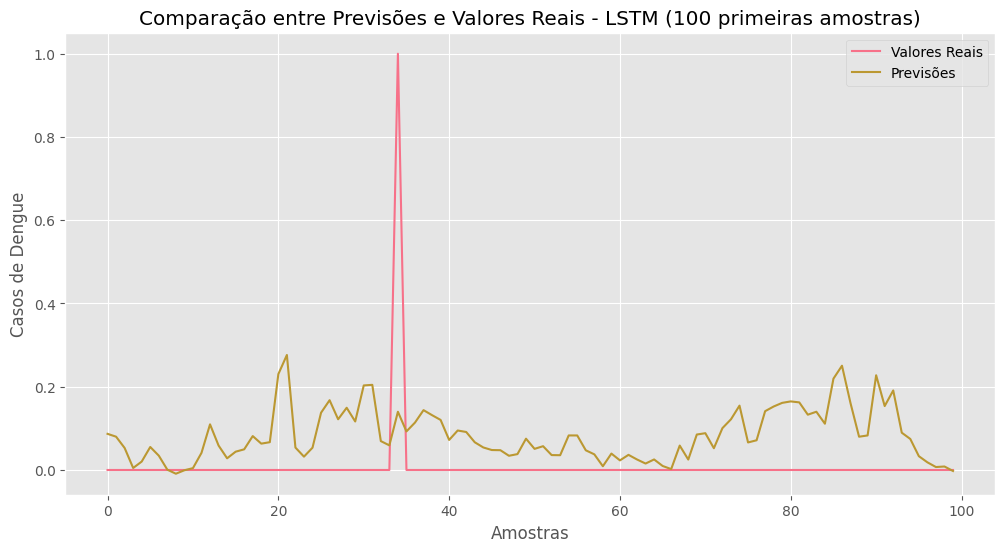

2853/2853 ━━━━━━━━━━━━━━━━━━━━ 3s 969us/step

Avaliação do Modelo Conv1D:
MSE: 7.76
MAE: 1.66


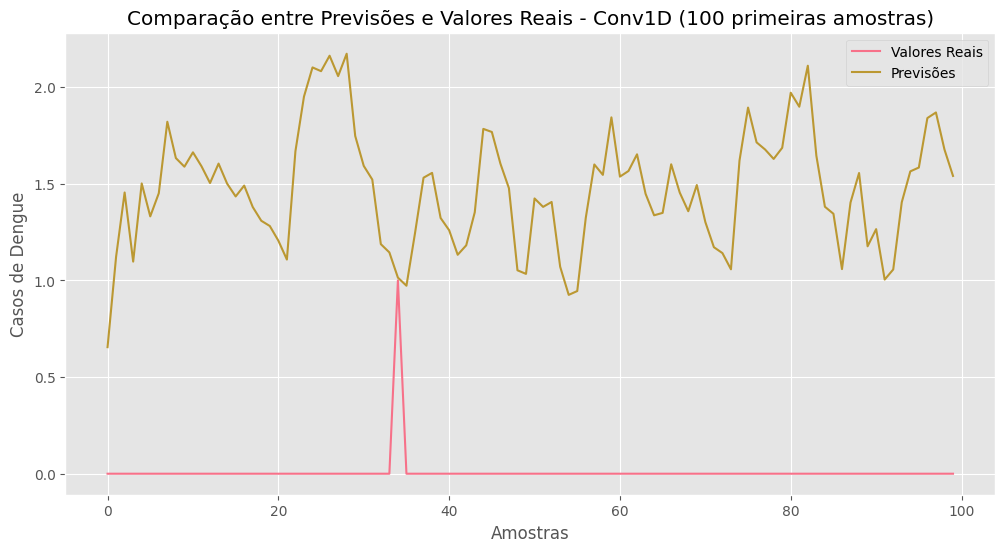


Comparação dos Modelos:
LSTM - MSE: 2.57, MAE: 0.35
Conv1D - MSE: 7.76, MAE: 1.66


In [25]:
# 6. Avaliação dos Modelos
# ========================

def evaluate_model(model, X_test, y_test, model_name):
    """Avalia o modelo nos dados de teste"""
    y_pred = model.predict(X_test).flatten()
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\nAvaliação do Modelo {model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    # Plotando previsões vs valores reais
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:100], label='Valores Reais')
    plt.plot(y_pred[:100], label='Previsões')
    plt.title(f'Comparação entre Previsões e Valores Reais - {model_name} (100 primeiras amostras)')
    plt.xlabel('Amostras')
    plt.ylabel('Casos de Dengue')
    plt.legend()
    plt.show()
    
    return mse, mae, y_pred

# Avaliando os modelos
lstm_mse, lstm_mae, lstm_pred = evaluate_model(lstm_model, X_test_norm, y_test_seq, 'LSTM')
conv1d_mse, conv1d_mae, conv1d_pred = evaluate_model(conv1d_model, X_test_norm, y_test_seq, 'Conv1D')

# Comparação dos modelos
print("\nComparação dos Modelos:")
print(f"LSTM - MSE: {lstm_mse:.2f}, MAE: {lstm_mae:.2f}")
print(f"Conv1D - MSE: {conv1d_mse:.2f}, MAE: {conv1d_mae:.2f}")

In [23]:
# 7. Análise de Sensibilidade às Variáveis Climáticas
# ==================================================

def analyze_feature_sensitivity(model, X_test, feature_names, scaler, model_name):
    """Analisa a sensibilidade do modelo às diferentes variáveis"""
    baseline_pred = model.predict(X_test).mean()
    
    sensitivities = []
    
    for i in range(len(feature_names)):
        # Criando uma cópia dos dados de teste
        X_perturbed = X_test.copy()
        
        # Perturbando uma feature de cada vez (aumentando em 10%)
        X_perturbed[:, :, i] *= 1.10
        
        # Normalizando os dados perturbados
        n_samples, n_timesteps, n_features = X_perturbed.shape
        X_perturbed_reshaped = X_perturbed.reshape(-1, n_features)
        X_perturbed_norm = scaler.transform(X_perturbed_reshaped).reshape(n_samples, n_timesteps, n_features)
        
        # Calculando a nova previsão média
        perturbed_pred = model.predict(X_perturbed_norm).mean()
        
        # Calculando a sensibilidade
        sensitivity = (perturbed_pred - baseline_pred) / baseline_pred * 100
        sensitivities.append(sensitivity)
    
    # Criando um DataFrame com os resultados
    sensitivity_df = pd.DataFrame({
        'Feature': feature_names,
        'Sensitivity (%)': sensitivities
    }).sort_values('Sensitivity (%)', ascending=False)
    
    print(f"\nTop 10 variáveis mais sensíveis para {model_name}:")
    print(sensitivity_df.head(10))
    
    return sensitivity_df

# Analisando sensibilidade para ambos os modelos
print("\nAnálise de Sensibilidade às Variáveis Climáticas:")
lstm_sensitivity = analyze_feature_sensitivity(lstm_model, X_test_norm, feature_names, scaler, 'LSTM')
conv1d_sensitivity = analyze_feature_sensitivity(conv1d_model, X_test_norm, feature_names, scaler, 'Conv1D')

# Plotando as sensibilidades comparativas
top_features = lstm_sensitivity['Feature'][:10]
plt.figure(figsize=(14, 7))
x = np.arange(len(top_features))
width = 0.35

plt.bar(x - width/2, lstm_sensitivity.set_index('Feature').loc[top_features]['Sensitivity (%)'], 
        width, label='LSTM', alpha=0.7)
plt.bar(x + width/2, conv1d_sensitivity.set_index('Feature').loc[top_features]['Sensitivity (%)'], 
        width, label='Conv1D', alpha=0.7)

plt.title('Comparação de Sensibilidade entre Modelos - Top 10 Variáveis')
plt.xlabel('Variável')
plt.ylabel('Sensibilidade (%)')
plt.xticks(x, top_features, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


Análise de Sensibilidade às Variáveis Climáticas:


NameError: name 'feature_names' is not defined

In [ ]:
# 8. Conclusões e Discussão
# =========================

# Identificando as top 3 variáveis mais sensíveis
top_3_lstm = lstm_sensitivity['Feature'].head(3).values
top_3_conv1d = conv1d_sensitivity['Feature'].head(3).values

print("\nConclusões e Discussão:")
print("1. Desempenho dos Modelos:")
print(f"   - LSTM alcançou MSE de {lstm_mse:.2f} e MAE de {lstm_mae:.2f}")
print(f"   - Conv1D alcançou MSE de {conv1d_mse:.2f} e MAE de {conv1d_mae:.2f}")
print(f"   - O modelo LSTM apresentou desempenho {'superior' if lstm_mse < conv1d_mse else 'inferior'} ao Conv1D")

print("\n2. Variáveis Mais Sensíveis:")
print(f"   - Para LSTM: {', '.join(top_3_lstm)}")
print(f"   - Para Conv1D: {', '.join(top_3_conv1d)}")

print("\n3. Interpretação:")
print("   - As variáveis mais sensíveis representam os fatores climáticos que mais impactam as previsões de dengue")
print("   - A similaridade/diferença entre as variáveis mais sensíveis dos dois modelos pode indicar padrões consistentes ou artefatos do modelo")

print("\n4. Recomendações para Melhoria:")
print("   - Realizar tuning de hiperparâmetros para ambos os modelos")
print("   - Experimentar com diferentes tamanhos de janela temporal")
print("   - Investigar a relação das top variáveis sensíveis com a biologia do vetor da dengue")
print("   - Considerar a inclusão de dados adicionais como densidade populacional ou histórico de campanhas de saúde")